# Combination tests

Some tests how well an agent does when given multiple tools

In [1]:
# Settings

import os
from dotenv import load_dotenv

# Zotero settings
load_dotenv()
zotero_api_key = os.environ.get("ZOTERO_API_KEY_READ") # A Zotero API key, here sourced from .env - read only access is enough
zotero_library_id = os.environ.get("ZOTERO_PERSONAL_LIBRARY_ID") # The library ID of the Zotero library to be accessed. Here a test group library
zotero_library_type = "user" # set the library type to either 'user' or 'group'. Make sure this corresponds to the library ID ('user' for your personal library)
zotero_docs_returned = 20 # number of documents returned from the zotero library
zot_get_fulltext = False # return full text from documents in the zotero library, if available
zot_type = "top" # "top" (top level items) or "items" (incl. sub level items, e.g. deleted)

# PDF Retriever Settings
lit_directory = "./test_data/" # directory with literature to load for the RAG
db_directory = "./test_chroma_db" # directory to save the vector store
pattern = r"[^\\/]*[\\/](?P<author>.+?) (?P<year>\d{4}) (?P<title>.+)\.pdf" # regex pattern to extract metadata from naming scheme in literature directory. Adjust as needed!
short_docs = True # shorten document from pages to chunks? (set chunk size below)
docs_returned = 6 # number of docs returned by the retriever(s)
retriever_type = "mmr" # "similarity"  or "mmr"


# Model settings

embedding_model = "nomic-embed-text" # very good embedding model for retrieval tasks

# textgen model. generates answers to questions, with retrieved documents as context
# textgen_model = "llama3.2"
textgen_model = "o3-mini-2025-01-31"
# textgen_model = "phi4", # phi4 is a rather powerful model, but requires more gpu compute (that is, it will be slower than llama3.2 if not enough gpu memory is available)

# reasoning model. handles deciding whether or not to query the retriever
# reasoning_model = "nemotron-mini" # nvidia's nemotron-mini is smaller, but still capable of the simple reasoning task we need (retrieve or not)
# reasoning_model = "llama3.2" # fast, but not very good at reasoning tasks
reasoning_model = "o3-mini-2025-01-31"
# reasoning_model = "qwq" # qwq is a rather powerful experimental reasoning model. However, as it is rather large (20b), it either requires a fair bit of GPU memory or will be very slow 

# selfquery model. generates queries for the retriever
# selfquery_model = "phi4" # phi4 seems better at query construction than llama3.2, but requires more gpu compute (i.e. may be slower)
# selfquery_model = "deepseek-r1:1.5b"
selfquery_model = "o3-mini-2025-01-31"


max_tokens = 2048 # maximum number of tokens to generate across models
temperature = 0 # temperature across models

verbose = True # print additional information on routing decisions etc.


## Setup

In [2]:
# set up the models

from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings
from openai import OpenAI
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv


load_dotenv()

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY")) # get API key from .env file

openai_models = [model.id for model in client.models.list()]

models = [textgen_model, reasoning_model, selfquery_model]
names = ["textgen_llm", "reasoning_llm", "selfquery_llm"]
for name, model in zip(names, models):
    if model in openai_models:
        if "o3" in model or o1 in model:
            print(f"Temperature parameter not supported for model {model}.")
            llm = ChatOpenAI(
                        model = model,
                        max_tokens = max_tokens, # max number of tokens to generate
                    )
        else:
            llm = ChatOpenAI(
                model = model,
                temperature=temperature,
                max_tokens = max_tokens, # max number of tokens to generate
            )
      
    else:
        llm = ChatOllama(
            model = model,
            temperature = temperature,
            num_predict = max_tokens, # max number of tokens to generate
        )
    globals()[f"{name}"] = llm # set the model as a global variable

embeddings = OllamaEmbeddings(model = embedding_model)

Temperature parameter not supported for model o3-mini-2025-01-31.
Temperature parameter not supported for model o3-mini-2025-01-31.
Temperature parameter not supported for model o3-mini-2025-01-31.


## Retriever Setups

In [3]:
# set up the zotero retriever

## get local ZoteroRetriever implementation until it is added to langchain_community
import sys
sys.path.append("D:/academicCloud/Python Scripts/langchain-zotero-retriever/src")
from langchain_zotero_retriever.retrievers import ZoteroRetriever

## pass settings for retriever
zotero_retriever = ZoteroRetriever(k = zotero_docs_returned, 
                                   get_fulltext = zot_get_fulltext, 
                                   library_id = zotero_library_id,
                                   library_type = zotero_library_type,
                                   api_key = zotero_api_key,
                                   type = zot_type,)


## direct lib access
from pyzotero import zotero

zot = zotero.Zotero(zotero_library_id, zotero_library_type, zotero_api_key) # zot for direct lib access


## get list of tags in the library. !Potentially add a way for dynamic or manual refreshes later!
library_tags = list(set(zot.tags())) # we use set() to remove any duplicates


## get list of available item types
import json
import urllib.request

url = "https://raw.githubusercontent.com/zotero/zotero-schema/refs/heads/master/schema.json"
response = urllib.request.urlopen(url)
data = json.loads(response.read())

item_types = set() # get unique itemTypes from data
for item in data["itemTypes"]:
    item_types.add(item["itemType"])

In [4]:
# Set up the PDF vector store

from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from re import match
import os

## check if the folder db_directory already exists. If not, creat it and load the documents into the vector store. Else, use the existing vector store. Makes a new DB for shortened docs

if short_docs:
    db_directory += "_short"

if not os.path.exists(db_directory):
    # load documents
    loader = PyPDFDirectoryLoader(lit_directory)
    docs = loader.load() # metadata tracks paper and page number; each page is a single document

    # extract metadata from file names (according to the pattern specified above)
    docs = [
        Document(
            doc.page_content,
            metadata={
                **doc.metadata,
                **({
                    "author_name": metadata.group("author"),
                    "year": metadata.group("year"),
                    "title": metadata.group("title")
                } if (metadata := match(pattern, doc.metadata["source"])) else {})
            }
        )
        for doc in docs
    ]


    # optional step: split the docs into smaller chunks to fit into context window of the model (model dependant, necessary for small models) -!! test this, shorter chunks may lead to bad retrieval results !!-
    #           potential remedy: use whole pages, but use the model to summarise each page before chaining it into the context
    if short_docs:
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,  # chunk size (characters)
            chunk_overlap=200,  # chunk overlap (characters)
            add_start_index=True,  # track index in original document
            )
        
        docs = text_splitter.split_documents(docs)

    # make doc vector store. as the vector store can get quite large (and takes time to initialize in memory), we use a chroma database to store the vectors    
    vector_store = Chroma(
        collection_name="lit_helper_test",
        embedding_function=embeddings,
        persist_directory=db_directory,  # save data locally
        )
    
    vector_store.add_documents(docs) # add docs

else:
    vector_store = Chroma(
        collection_name="lit_helper_test",
        embedding_function=embeddings,
        persist_directory=db_directory,  # save data locally
    )


In [5]:
# set up the self querying retriever

from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.chains.query_constructor.base import get_query_constructor_prompt
from langchain.chains.query_constructor.base import StructuredQueryOutputParser
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_community.query_constructors.chroma import ChromaTranslator

metadata_field_info = [
    # note that the attribute infos can have a vast influence on the performance of the retriever (likely model dependant)
    #   The name seems to be most important when the model chooses the filter - with notable side effects for other attributes when changing the name of one!
    #   Beware that the names here need to correspond to the names in the metadata of the documents set above (changes in the name here require updating the chroma database)
    AttributeInfo(
        name = "author_name",
        description="The paper author's last name. Abbreviated with et al. for more than two authors.",
        type="string",
    ),
    AttributeInfo(
        name = "year",
        description="The year of publication",
        type="string",
    ),
    AttributeInfo(
        name = "title",
        description="The title of the paper",
        type="string",
    ),
    AttributeInfo(
        name = "page",
        description="The page number of the paper",
        type="string",
    ),
    AttributeInfo(
        name = "source",
        description="The file path of the paper",
        type="string",
    ),
]

document_content_description = "A passage from a scientific paper"


retrieval_prompt = get_query_constructor_prompt( # we're using a premade prompt for the query constructor
    document_contents=document_content_description,
    attribute_info=metadata_field_info,
    # examples = retriever examples, # we can optionally add examples for the model to fine tune the retrieval. See https://github.com/langchain-ai/langchain/blob/master/cookbook/self_query_hotel_search.ipynb
)

output_parser = StructuredQueryOutputParser.from_components( # we're also using a premade output parser
    fix_invalid=True, # this automatically fixes invalid queries (that is, it should avoid errors being thrown when the model constructs an invalid query)
    ) 

query_constructor = retrieval_prompt | selfquery_llm | output_parser # make the query constructor chain

## pass settings (adjust as needed)
if retriever_type == "mmr":
    search_type="mmr" # MMR (Maximal Marginal Relevance) aims to diversify search results. the amount of diversification is set via the lambda_mult parameter
    search_kwargs={"k": docs_returned, # make sure the number of documents passed (k) fits into the context window
                       "fetch_k": docs_returned * 5, # could be adjusted, potentially run tests
                       "lambda_mult": 0.8 # amount of diversification, with 0 being maximum diversity
                       }

if retriever_type == "similarity":
    search_type="similarity" # similarity score; optionally with threshold ("similarity_score_threshold" with "score_threshold" kwarg)
    search_kwargs={"k": docs_returned} # make sure the number of documents passed (k) fits into the context window


self_query_retriever = SelfQueryRetriever(
    query_constructor=query_constructor,
    vectorstore=vector_store,
    structured_query_translator=ChromaTranslator(), # we need to specify the translator for our database scheme, e.g. Chroma
    search_type=search_type,
    search_kwargs=search_kwargs, 
)

if verbose: print(retrieval_prompt.format(query="{query}")) # print out the prompt used for the query constructor

Your goal is to structure the user's query to match the request schema provided below.

<< Structured Request Schema >>
When responding use a markdown code snippet with a JSON object formatted in the following schema:

```json
{
    "query": string \ text string to compare to document contents
    "filter": string \ logical condition statement for filtering documents
}
```

The query string should contain only text that is expected to match the contents of documents. Any conditions in the filter should not be mentioned in the query as well.

A logical condition statement is composed of one or more comparison and logical operation statements.

A comparison statement takes the form: `comp(attr, val)`:
- `comp` (eq | ne | gt | gte | lt | lte | contain | like | in | nin): comparator
- `attr` (string):  name of attribute to apply the comparison to
- `val` (string): is the comparison value

A logical operation statement takes the form `op(statement1, statement2, ...)`:
- `op` (and | or | not

# Agent Framework

In [6]:
## Zotero Retriever Tool

from typing import Optional, Union, List
from langchain_core.tools import StructuredTool


def zot_retrieve(query: str, 
                itemType: Optional[str], 
                tag: Optional[Union[str, List[str]]], 
                qmode: str = "everything", 
                since: Optional[int] = None):

    if verbose: print("---ZOTERO RETRIEVER CALL---") 

    retrieved_docs = zotero_retriever.invoke(query, itemType = itemType, tag = tag, qmode = qmode, since = since)
    serialized_docs = "\n\n".join(
        (f"Metadata: { {key: doc.metadata[key] for key in doc.metadata if key != 'abstractNote'} }\n" f"Abstract: {doc.metadata['abstractNote']}\n")
        for doc in retrieved_docs
    )

    return serialized_docs, retrieved_docs

zot_description = f"""Search and return relevant documents from a Zotero library. The following search parameters can be used:

    Args:
        query: str: The search query to be used. Try to keep this specific and short, e.g. a specific topic or author name
        itemType: Optional. Type of item to search for (e.g. "book" or "journalArticle"). Multiple types can be passed as a string seperated by "||", e.g. "book || journalArticle". Defaults to all types
        tag: Optional. For searching over tags attached to library items. If documents tagged with multiple tags are to be retrieved, pass them as a list. If documents with any of the tags are to be retrieved, pass them as a string separated by "||", e.g. "tag1 || tag2"
        qmode: Search mode to use. Changes what the query searches over. "everything" includes full-text content. "titleCreatorYear" to search over title, authors and year. Defaults to "everything"
        since: Return only objects modified after the specified library version. Defaults to return everything
    """

zotero_retriever_tool = StructuredTool.from_function(
    func=zot_retrieve,
    name = "ZoteroLibrary",
    description = zot_description,
    return_direct=True,
)

**To do**: Rewrite the retriever tool, so that it is not directly self-querying, but a function that can be used as a tool, with the model making use of the metadata filter options

In [ ]:
## Self-querying retriever tool

from langchain_core.messages import ToolMessage


def sq_retrieve(query: str):
    if verbose: print("---LITERATURE RETRIEVER CALL---") 

    if verbose: print(f'Input: {query}')
    if verbose: print(f'Retriever Query: {query_constructor.invoke(query)}')

    retrieved_docs = self_query_retriever.invoke(query) # use full conversation state for querying, apart from tool calls
    serialized_docs = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        # (f"Source: {doc.metadata["source"]}\n" f"Page: {doc.metadata["page"]}\n" f"Content: {doc.page_content}") # Alternate format. Does not make the model better at reporting the page, but changes the output
        for doc in retrieved_docs
    )

    if verbose: print(f"Retrieved documents:\n {serialized_docs}")

    return serialized_docs, retrieved_docs

sq_description = f"""Search and return relevant passages from a personal collection of scientific literature.
The retriever automatically constructs a query. Make sure to pass sufficient information to accomodate metadata filtering. 
E.g., when a specific author is requested, make sure to pass this information to the retriever.
The retriever can accomodate the following metadata fields to search for literature: {metadata_field_info}
"""

literature_retriever_tool = StructuredTool.from_function(
    func=sq_retrieve,
    name="LiteratureRetriever",
    description=sq_description,
    return_direct=True,
)

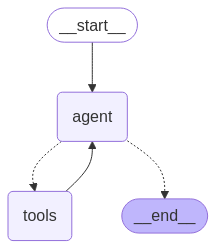

In [8]:
# Graph
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display

tool_node = ToolNode([literature_retriever_tool, zotero_retriever_tool])

model_with_tools = reasoning_llm.bind_tools([literature_retriever_tool, zotero_retriever_tool])

def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

# add memory for prolongued converstations. For now, saving it in memory is sufficient
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

# Test

In [9]:
input_message = "Can you check my Zotero library for texts by Dahlberg?"

config = {"configurable": {"thread_id": "test_thread"}} # Specify an ID for the thread

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you check my Zotero library for texts by Dahlberg?
================================== Ai Message ==================================
Tool Calls:
  ZoteroLibrary (call_D0wTkAeM2v3aqXYoLqrOWbWt)
 Call ID: call_D0wTkAeM2v3aqXYoLqrOWbWt
  Args:
    query: Dahlberg
    itemType: None
    tag: None
    qmode: titleCreatorYear
---ZOTERO RETRIEVER CALL---
================================= Tool Message =================================
Name: ZoteroLibrary

("Metadata: {'key': 'WZZ5BFKH', 'version': 3023, 'itemType': 'journalArticle', 'tags': 'Counterpublic Theory, Deliberative Democratic Theory, Public Sphere, Radical Democracy', 'authors': 'Lincoln Dahlberg', 'title': 'The Internet, deliberative democracy, and power: Radicalizing the public sphere', 'publication': 'International Journal of Media and Cultural Politics', 'volume': '3', 'issue': '1', 'pages': '47-64', 'date': '1 January 2007', 'DOI': '', 'attachm

In [10]:
input_message = "Are any of the texts by this author available in the literature retriever?"

config = {"configurable": {"thread_id": "test_thread"}} # Specify an ID for the thread

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Are any of the texts by this author available in the literature retriever?
================================== Ai Message ==================================
Tool Calls:
  LiteratureRetriever (call_7yf6JhagMfQfqaftXp0Js6mY)
 Call ID: call_7yf6JhagMfQfqaftXp0Js6mY
  Args:
    query: author:Dahlberg
---LITERATURE RETRIEVER CALL---
Input: author:Dahlberg
Retriever Query: query=' ' filter=Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='author_name', value='Dahlberg') limit=None
Retrieved documents: Source: {'author_name': 'Dahlberg', 'page': 16, 'source': 'test_data\\Dahlberg 2011 Re-Constructing Digital Democracy.pdf', 'start_index': 3236, 'title': 'Re-Constructing Digital Democracy', 'year': '2011'}
Content: Democracy: Politics Between Abundance and Lack . Manchester: University of Manchester 
Press, 123–132.
Negri A (2008a) The Porcelain Workshop: For a New Grammar of Politics. New York: Semiotext(e)

In [11]:
input_message = "What does this text say about deliberative conceptions of digital democracy?"

config = {"configurable": {"thread_id": "test_thread"}} # Specify an ID for the thread

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What does this text say about deliberative conceptions of digital democracy?
================================== Ai Message ==================================

The text critiques the liberal-individualist view and argues that a deliberative conception of digital democracy envisions the transformation of private individuals into publicly oriented democratic subjects. In this view, online communication isn’t just about individual expression or aggregating isolated interests but about fostering rational deliberation that cultivates a shared public opinion. This process helps form a public sphere where diverse voices participate in reasoned debate, leading to a consensus that is not pre-given but developed through collective inquiry. In essence, the deliberative approach presents digital democracy as a space where debates and reasoned discussions transform individuals into engaged citizens who scrutinize and i

In [12]:
input_message = "What authors does the text refer to in this regard?"

config = {"configurable": {"thread_id": "test_thread"}} # Specify an ID for the thread

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What authors does the text refer to in this regard?
================================== Ai Message ==================================

The text refers primarily to Jürgen Habermas and Graham T. In discussing deliberative conceptions of digital democracy, it cites Habermas’s seminal work, "The Theory of Communicative Action" (1984), to underline the idea of generating a rational public sphere where private individuals are transformed into deliberative, publicly engaged citizens. It also references Graham T (2009), whose work on net-based public spheres supports this perspective. These authors are used to illustrate the shift from viewing digital democracy merely as an aggregation of individual interests to understanding it as a participatory, contestable arena where rational debate and consensus-building take place.


In [15]:
input_message = "Re-query the retriever and look for more passages in the same text, specifically relating to the democratic subject in deliberative democratic approaches?"

config = {"configurable": {"thread_id": "test_thread"}} # Specify an ID for the thread

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Re-query the retriever and look for more passages in the same text, specifically relating to the democratic subject in deliberative democratic approaches?
================================== Ai Message ==================================
Tool Calls:
  LiteratureRetriever (call_un6QcOGDQyasQHQ3Xxf6ye8X)
 Call ID: call_un6QcOGDQyasQHQ3Xxf6ye8X
  Args:
    query: Re-Constructing Digital Democracy democratic subject deliberative digital democracy
---LITERATURE RETRIEVER CALL---
Input: Re-Constructing Digital Democracy democratic subject deliberative digital democracy
Retriever Query: query='Re-Constructing Digital Democracy democratic subject deliberative digital democracy' filter=None limit=None
Retrieved documents: Source: {'author_name': 'Dahlberg', 'page': 4, 'source': 'test_data\\Dahlberg 2011 Re-Constructing Digital Democracy.pdf', 'start_index': 1592, 'title': 'Re-Constructing Digital Democracy', 'year':

## Alternative approach

Build an agentic workflow with the following components:

1) A supervisor deciding which tool/subagent to use


2) The literature retriever, consisting of

    a) the self-querying retriever

    b) the answer-generation step (check if this is necessary, or if it can be handled by the supervisor)


3) The Zotero Retriever, consisting of

    a) the zotero retriever tool

    b) an llm with the zotero tool bound, able to query the retriever (to make use of its function arguments)


In [13]:
# ## Self-querying retriever tool

# from langchain_core.messages import ToolMessage
# from langgraph.graph import add_messages, MessagesState
# from uuid import uuid4


# def sq_retrieve(state: MessagesState):
#     if verbose: print("---LITERATURE RETRIEVER CALL---") 

#     tool_call_id = uuid4().hex # generate a tool call ID

#     if verbose: print(f'Tool Call ID: {tool_call_id}')
#     if verbose: print(f'Input: {state["messages"]}')
#     if verbose: print(f'Retriever Query: {query_constructor.invoke(state["messages"])}')

#     conversation_messages = [
#         message.content
#         for message in state["messages"]
#         if message.type in ("human", "system")
#         or (message.type == "ai" and not message.tool_calls)
#     ]

#     retrieved_docs = self_query_retriever.invoke(conversation_messages) # use full conversation state for querying, apart from tool calls
#     serialized = "\n\n".join(
#         (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
#         # (f"Source: {doc.metadata["source"]}\n" f"Page: {doc.metadata["page"]}\n" f"Content: {doc.page_content}") # Alternate format. Does not make the model better at reporting the page, but changes the output
#         for doc in retrieved_docs
#     )

#     tool_message = ToolMessage(content = serialized, tool_call_id=tool_call_id)

#     # update state
#     state["messages"] = add_messages(state["messages"], tool_message)
#     return state

# sq_description = f"""Search and return relevant passages from a personal collection of scientific literature.
# The retriever automatically constructs a query. DO NOT change the user input. Always pass the user input directly to the retriever.
# The retriever can accomodate the following metadata fields to search for literature: {metadata_field_info}
# """

# literature_retriever_tool = StructuredTool.from_function(
#     func=sq_retrieve,
#     name="LiteratureRetriever",
#     description=sq_description,
#     return_direct=True,
# )